# Exploring a neural dataset

Revealing the latent structure of fMRI responses to natural scenes

Analyzing the Natural Scenes dataset reveals high-dimensional latent
structure in neural responses.

In [1]:
# TODO uncomment before final packaging
# %pip install git+https://github.com/BonnerLab/ccn-tutorial.git


In [2]:
from pathlib import Path
import requests
import typing
import warnings

from loguru import logger
import numpy as np
import pandas as pd
import xarray as xr
import nibabel as nib
import nilearn.plotting
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, NMF
from umap import UMAP

import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from IPython.display import display

from utilities.brain import (
    load_dataset,
    average_data_across_repetitions,
    load_stimuli,
    plot_brain_map,
)


In [3]:
%matplotlib inline

sns.set_theme(
    context="notebook",
    style="white",
    palette="deep",
    rc={"legend.edgecolor": "None"},
)
set_matplotlib_formats("svg")

pd.set_option("display.max_rows", 5)
pd.set_option("display.max_columns", 10)
pd.set_option("display.precision", 3)
pd.set_option("display.show_dimensions", False)

xr.set_options(display_max_rows=3, display_expand_data=False)

warnings.filterwarnings("ignore")

In [4]:
random_state = 0
rng = np.random.default_rng(seed=random_state)


## The Natural Scenes fMRI Dataset (NSD)

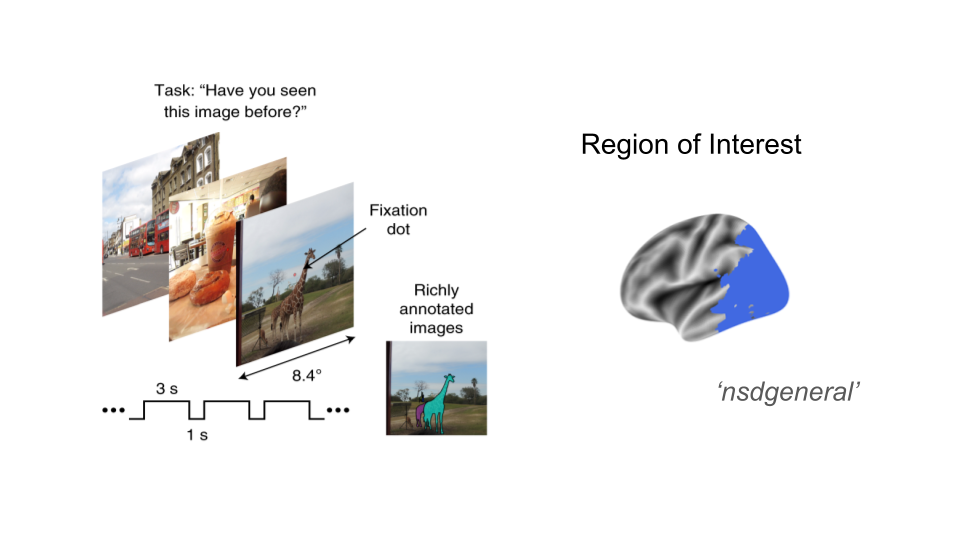

NSD is the largest fMRI dataset on human vision, with 7T fMRI responses
(1.8mm isotropic voxels) obtained from 8 adult participants. The
experiment involved a continuous recognition task while participants
observed natural scene images from the Microsoft Common Objects in
Context (COCO) database (Lin et al., 2014).

Let’s load the dataset. This data contains neural responses to 872
images from ~15,000 voxels reliably modulated by the visual stimuli
during the NSD experiment.

In [5]:
data = average_data_across_repetitions(load_dataset(subject=0, roi="general"))

display(data)


<xarray.DataArray 'fMRI betas' (presentation: 700, neuroid: 15724)>
0.4915 0.2473 0.08592 0.05828 -0.1315 ... -0.2126 -0.6315 -0.5751 -0.5354
Coordinates: (3/4)
 x (neuroid) uint8 12 12 12 12 12 12 12 ... 71 72 72 72 72 72 72
 y (neuroid) uint8 21 22 22 22 22 22 23 ... 34 29 29 30 30 30 31
 ... ...
 stimulus_id (presentation) object 'image02950' ... 'image72948'
Dimensions without coordinates: presentation, neuroid
Attributes: (3/8)
 resolution: 1pt8mm
 preprocessing: fithrf_GLMdenoise_RR
 ... ...
 postprocessing: averaged across first two repetitions xarray.DataArray 'fMRI betas' presentation : 700 neuroid : 15724 0.4915 0.2473 0.08592 0.05828 ... -0.2126 -0.6315 -0.5751 -0.5354 array([[ 0.4915219 , 0.24733381, 0.08592446, ..., -0.366651 ,
 0.30723202, 0.43520752],
 [ 0.1664538 , -0.10728736, 0.35630295, ..., 0.8608913 ,
 0.03464809, 0.11020081],
 [ 1.0357349 , 0.77598304, 0.35813144, ..., 0.2419075 ,
 0.81557286, 0.38667244],
 ...,
 [-0.05812129, -0.4539395 , 0.41060364, ..., 0.5738151 ,
 -0.718189 , -0.638827 ],
 [-0.00340644, -1.0050421 , 0.7278904 , ..., 0.580743 ,
 -0.50856245, -0.2727615 ],
 [-1.2668517 , -1.4769105 , -0.3562023 , ..., -0.63146234,
 -0.575121 , -0.5354325 ]], dtype=float32) Coordinates: (4) x (neuroid) uint8 12 12 12 12 12 ... 72 72 72 72 72 array([12, 12, 12, ..., 72, 72, 72], dtype=uint8) y (neuroid) uint8 21 22 22 22 22 ... 29 30 30 30 31 array([21, 22, 22, ..., 30, 30, 31], dtype=uint8) z (neuroid) uint8 47 45 46 47 48 ... 46 45 46 49 49 array([47, 45, 46, ..., 46, 49, 49], dtype=uint8) stimulus_id (presentation) object 'image02950' ... 'image72948' array(['image02950', 'image02990', 'image03049', 'image03077',
 'image03146', 'image03157', 'image03164', 'image03171',
 'image03181', 'image03386', 'image03434', 'image03449',
 'image03489', 'image03626', 'image03682', 'image03687',
 'image03729', 'image03809', 'image03842', 'image03847',
 'image03856', 'image03913', 'image03951', 'image04051',
 'image04058', 'image04129', 'image04156', 'image04249',
 'image04423', 'image04436', 'image04667', 'image04690',
 'image04768', 'image04786', 'image04835', 'image04892',
 'image04930', 'image05034', 'image05106', 'image05204',
 'image05301', 'image05338', 'image05459', 'image05542',
 'image05583', 'image05602', 'image05714', 'image06199',
 'image06222', 'image06431', 'image06444', 'image06489',
 'image06514', 'image06521', 'image06558', 'image06801',
 'image07007', 'image07039', 'image07120', 'image07207',
 'image07366', 'image07418', 'image07480', 'image07654',
 'image07840', 'image07859', 'image07944', 'image07948',
 'image08006', 'image08109', 'image08204', 'image08225',
 'image08394', 'image08415', 'image08435', 'image08465',
 'image08509', 'image08646', 'image08807', 'image08843',
...
 'image64615', 'image64621', 'image64867', 'image64880',
 'image65010', 'image65148', 'image65253', 'image65267',
 'image65376', 'image65445', 'image65769', 'image65799',
 'image65821', 'image65872', 'image65920', 'image65943',
 'image66004', 'image66216', 'image66278', 'image66330',
 'image66464', 'image66489', 'image66580', 'image66773',
 'image66836', 'image66946', 'image66976', 'image67045',
 'image67113', 'image67204', 'image67237', 'image67295',
 'image67742', 'image67802', 'image67829', 'image68168',
 'image68278', 'image68339', 'image68418', 'image68471',
 'image68741', 'image68814', 'image68842', 'image68858',
 'image68897', 'image69007', 'image69130', 'image69214',
 'image69240', 'image69502', 'image69614', 'image69839',
 'image69854', 'image70075', 'image70095', 'image70193',
 'image70232', 'image70335', 'image70360', 'image70427',
 'image70505', 'image71229', 'image71232', 'image71241',
 'image71410', 'image71450', 'image71753', 'image71894',
 'image72015', 'image72080', 'image72209', 'image72312',
 'image72510', 'image72605', 'image72719', 'image72948'],
 dtype=object) Indexes: (0) Attributes: (8) resolution : 1pt8mm preprocessing : fithrf_GLMdenoise_RR z_score : True roi : general subject : 0 brain shape : [ 81 1

> **Some fMRI preprocessing details**
>
> We utilized the NSD single-trial betas, preprocessed in 1.8 mm
> volumetric space and denoised using the GLMdenoise technique (version
> 3;“betas_fithrf_GLMdenoise_RR”). The betas were converted to Z-scores
> within each scanning session and averaged across repetitions for each
> stimulus.

Here are some examples of stimuli that we analyzed.

In [6]:
def view_stimuli(stimuli: xr.DataArray, *, n: int = 10) -> None:
    fig = plt.figure(figsize=(12, 4))
    image_grid = ImageGrid(
        fig=fig,
        rect=(1, 1, 1),
        nrows_ncols=(1, n),
        share_all=True,
    )
    for i_image in range(n):
        image_grid[i_image].imshow(stimuli[i_image])
        image_grid[i_image].axis("off")
    fig.show()


stimuli = load_stimuli()
view_stimuli(stimuli)


### The neural eigenspectrum

Now we can apply PCA to the neural responses and plot the eigenspectrum
of the data!

In [7]:
def view_eigenspectrum(pca: PCA, *, log: bool = False) -> None:
    eigenvalues = pd.DataFrame(pca.explained_variance_, columns=["eigenvalue"]).assign(
        rank=1 + np.arange(pca.n_components_)
    )

    fig, ax = plt.subplots(figsize=(6, 6))
    sns.lineplot(
        ax=ax,
        data=eigenvalues.loc[eigenvalues["rank"] < pca.n_components_],
        x="rank",
        y="eigenvalue",
    )
    sns.despine(ax=ax)
    if log:
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_ylim(bottom=1)
    fig.show()


pca = PCA()
pca.fit(data)

view_eigenspectrum(pca)


On this plot, the first few PCs have substantial variance while there
appears to be negligible variance after about rank 20. How can we
interpret these PCs of different variance levels? There are some simple
ways to visualize these PCs.

#### Visualizing principal components

In [8]:
def view_images_as_scatterplot(
    x: np.ndarray, y: np.ndarray, *, stimuli: xr.DataArray
) -> None:
    fig, ax = plt.subplots(figsize=(10, 10))
    for i_stimulus in range(len(stimuli)):
        image_box = OffsetImage(stimuli[i_stimulus].values, zoom=0.3)
        image_box.image.axes = ax

        ab = AnnotationBbox(
            image_box,
            xy=(x[i_stimulus], y[i_stimulus]),
            xycoords="data",
            frameon=False,
            pad=0,
        )
        ax.add_artist(ab)

    ax.set_xlim([x.min(), x.max()])
    ax.set_ylim([y.min(), y.max()])
    ax.axis("off")
    fig.show()


def view_images_at_poles(
    x: np.ndarray,
    *,
    stimuli: xr.DataArray,
    n_images_per_pole: int = 5,
    label: str | None = None,
) -> None:
    indices = np.argsort(x, axis=0)

    fig = plt.figure(figsize=(12, 4))
    image_grid = ImageGrid(
        fig=fig,
        rect=(1, 1, 1),
        nrows_ncols=(1, 2 * n_images_per_pole + 1),
        share_all=True,
    )
    for i_image in range(n_images_per_pole):
        image_grid[i_image].imshow(stimuli[indices[i_image]])
        image_grid[i_image].axis("off")
        image_grid[-i_image - 1].imshow(stimuli[indices[-i_image - 1]])
        image_grid[-i_image - 1].axis("off")

    for ax in image_grid:
        ax.axis("off")

    if label is not None:
        ax = image_grid[n_images_per_pole]
        ax.text(
            0.5,
            0.5,
            label,
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
        )
    fig.show()


The first method is to plot the stimuli on a scatter plot, designating
their X and Y coordinates to be their scores along two PCs of interest.
This allows us to observe potential clustering of the stimuli.

In [9]:
data_pca = pca.transform(data)
view_images_as_scatterplot(data_pca[:, 0], data_pca[:, 1], stimuli=stimuli)


Alternativley, we can focus on the stimuli with the highest or lowest
scores along a given PC. It provides simple clues of what this PC might
be sensitive to, which could be features ranging from low to high
complexity level.

In [10]:
for rank in [1, 2, 3, 10, 50, 100]:
    view_images_at_poles(data_pca[:, rank - 1], stimuli=stimuli, label=f"rank {rank}")


> **What about other methods?**
>
> Interpreting PCs can be challenging especially when we rely solely on
> visual inspection. This difficulty arises, in part, because many
> natural features are non-negative. As a result, methods like
> nonnegative matrix factorization (NMF) often offer more interpretable
> dimensions than PCA.
>
> ``` python
> scaler = MinMaxScaler()
> scaler.fit(data)
>
> nmf = NMF(n_components=2, random_state=random_state)
> data_nmf = nmf.fit_transform(scaler.transform(data))
>
> view_images_as_scatterplot(data_nmf[:, 0], data_nmf[:, 1], stimuli=stimuli)
> ```
>
> 
>
> Similarly, we can inspect the stimuli with highest or closest-to-zero
> values along each dimension.
>
> ``` python
> for dim in range(2):
>     view_images_at_poles(data_pca[:, dim], stimuli=stimuli, label=f"dim {dim+1}")
> ```
>
> 
>
> 
>
> <!-- What can we interpret here? -->
>
> <!-- if NMF can be done in a linear manner, should we stress that PCA is better for being a linear methods? -->
>
> Nonetheless, PCA has unique benefits that shouldn’t be overlooked. For
> instance, PCA offers closed-form solutions and non-stochastic
> outcomes. They’re also well characterized mathematically. Moreover,
> because PCA is essentially rotateing data to present it in a clearer
> perspective, it is able to preserve all the original information.

#### Logarithmic scale

Given these visualization, we might deem that the higher-rank PCs are
non-interpretable and thus follow the common practice to drop them.
However, before doing so, let’s try visualizing the spectrum on a
logarithmic scale for both axes:

In [13]:
view_eigenspectrum(pca, log=True)


On a log-log scale, the spectrum shows no obvious discontinuity! This
suggests that the neural population code has a scale-free structure and
its latent dimensionality is likely higher than 20!

What kind of structure is this? We observe that the spectrum is
approximately linear on this log-log scale, suggesting that the
eigenvalues obey a power law:

$$\log{\lambda_\text{rank}} \approx \alpha \log{\left( \text{rank} \right)} + c \implies \lambda_\text{rank} \propto \left( \text{rank} \right)^\alpha$$

#### Power laws

A power law is a relationship of the form $f(x) \propto x^{\alpha}$,
where $\alpha$ is termed the *index* of the power law, or the *power law
exponent*. It is *scale-free* because $f(kx) \propto f(x)$.

Power laws are ubiquitious in nature, arising in all sorts of systems:

-   word frequencies in natural language (Zipf’s law)
-   wealth distribution (Pareto principle)
-   ferromagnetism (Ising model)

Nevertheless, a power law relationshop will not be observed when the
data

-   is random
-   has certain characteristic scale

#### Power law in neural networks